In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,make_scorer,recall_score, accuracy_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

import nltk
from nltk.stem import WordNetLemmatizer
import re

## Load in our Data

In [2]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
df_train.shape

(7613, 5)

In [10]:
df_test.shape

(3263, 4)

## Initial EDA

Exploring our data to understand initial parameters:

In [11]:
df_train.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [12]:
df_train.keyword.value_counts().sort_values(ascending = False)

fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [13]:
df_train["text_words"] = df_train.text.apply(lambda x: len(x.split()))
df_test["text_words"] = df_test.text.apply(lambda x: len(x.split()))

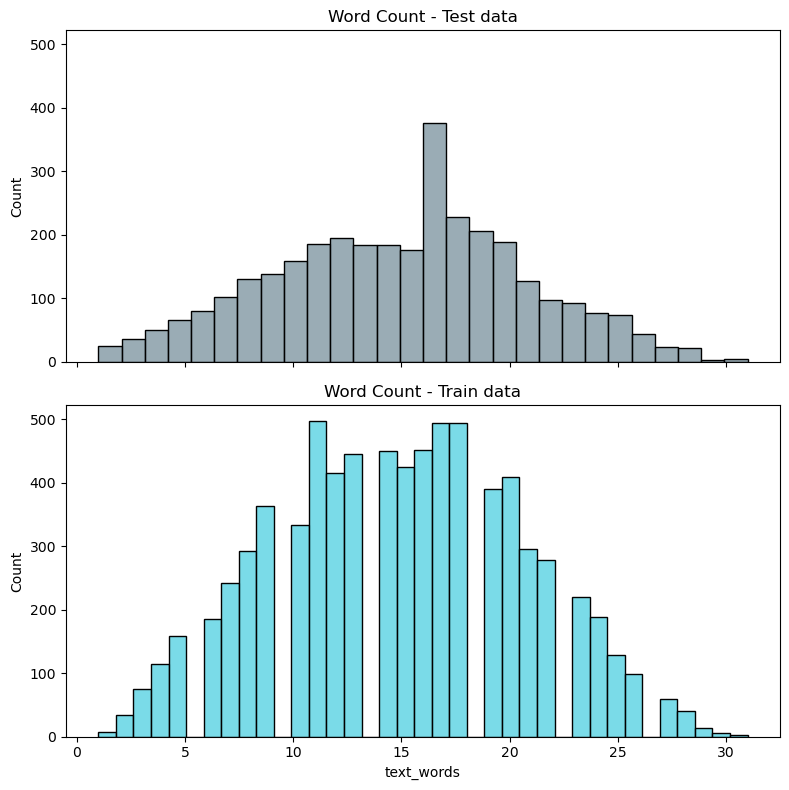

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_test, x=df_test['text_words'], color='#78909c', ax=axes[0]).set(title='Word Count - Test data')
sns.histplot(data=df_train, x=df_train['text_words'], color='#4dd0e1', ax=axes[1]).set(title='Word Count - Train data');

# Add a Super Title
#fig.suptitle('Distribution of Word Count by Dataset', ha='center')
#plt.savefig("Word_Count_data.png")

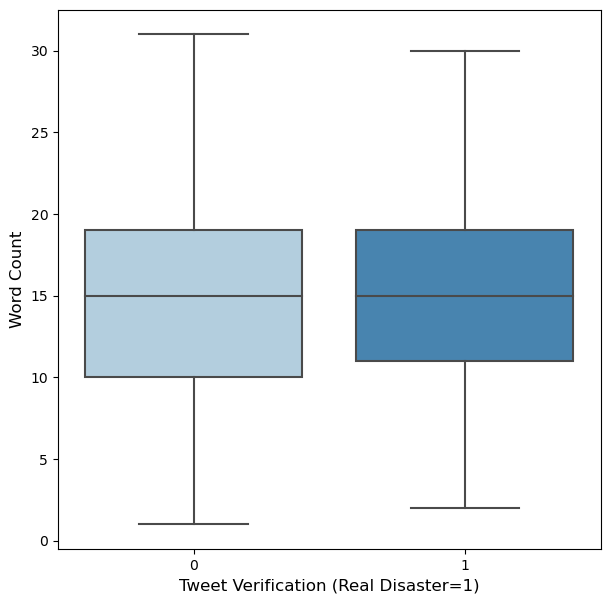

In [15]:
#df_train.boxplot(by ='target', column =['text_words'], grid = False);

plt.figure(figsize=(7,7))
word_count = sns.boxplot(x='target', y='text_words', data=df_train, palette = "Blues")
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Word Count', fontsize=12);

Note: the word count for 'real' and 'not real' disasters has a similar distribution, with a slightly shorter word count for 'not real' disasters

In [16]:
#word_count vs character_count
df_train['character_count'] = df_train['text'].str.len()
df_test['character_count'] = df_test['text'].str.len()

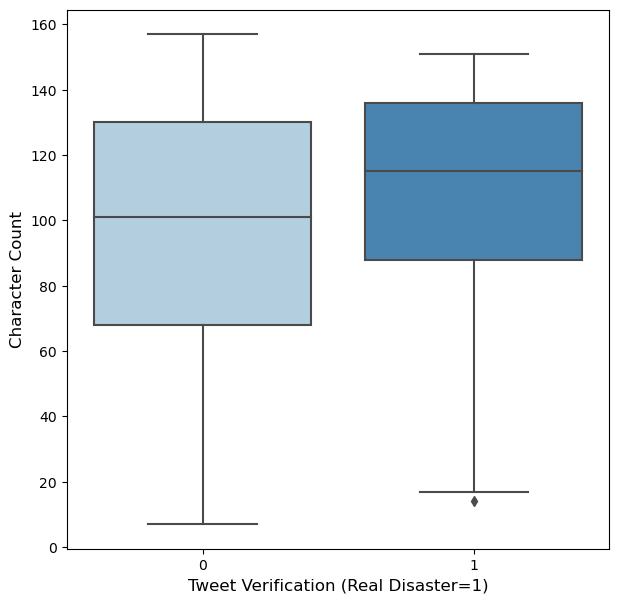

In [17]:
plt.figure(figsize=(7,7))
word_count = sns.boxplot(x='target', y='character_count', data=df_train, palette = "Blues")
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Character Count', fontsize=12);

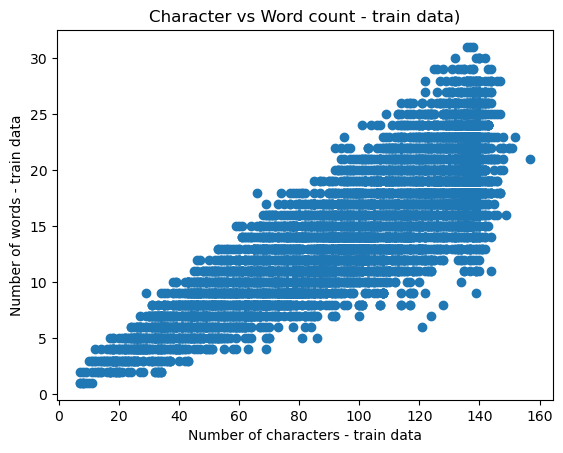

In [18]:
plt.scatter(df_train["character_count"], df_train["text_words"])

plt.xlabel("Number of characters - train data")
plt.ylabel("Number of words - train data")
plt.title("Character vs Word count - train data)")

plt.show()

In [19]:
df_train_target = df_train.groupby(['target']).aggregate({'character_count':'mean','text_words':'mean'})
df_train_target.reset_index()

,target,character_count,text_words
0,0,95.706817,14.704744
1,1,108.113421,15.167533


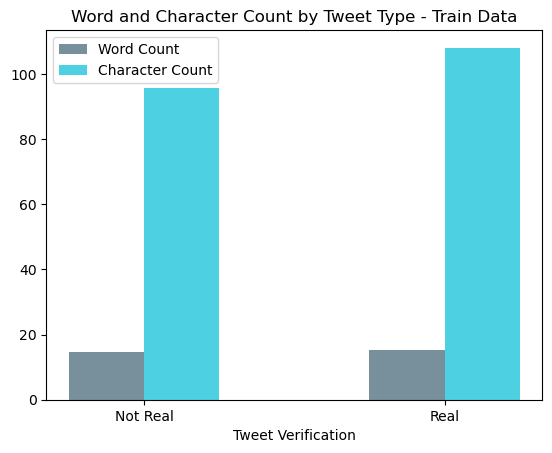

In [20]:
plt.bar(np.arange(2), df_train_target['text_words'], color = '#78909c',
        width = 0.25,
        label='Word Count')
plt.bar(np.arange(2)+.25, df_train_target["character_count"], color = '#4dd0e1',
        width = 0.25,
        label='Character Count')
  
plt.xlabel("Tweet Verification")
plt.title("Word and Character Count by Tweet Type - Train Data")

plt.xticks(np.arange(2)+.25/2,['Not Real', 'Real'])
plt.legend()

  
plt.show()

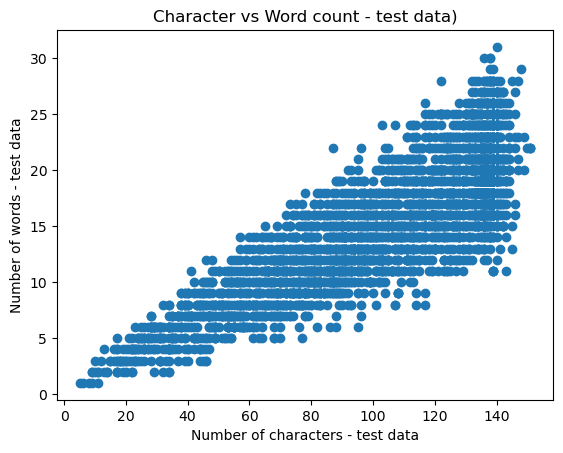

In [21]:
plt.scatter(df_test["character_count"], df_test["text_words"])

plt.xlabel("Number of characters - test data")
plt.ylabel("Number of words - test data")
plt.title("Character vs Word count - test data)")

plt.show()

In [22]:
filtered_df_train = df_train.dropna(subset = ['keyword'])

#df_train['count_keyword'] = df_train.apply(lambda x: x['text'].count(x['keyword']), axis=1)
filtered_df_train['count_keyword'] = [x.text.count(x.keyword) for x in filtered_df_train.itertuples()]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_80796/1697830117.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_train['count_keyword'] = [x.text.count(x.keyword) for x in filtered_df_train.itertuples()]


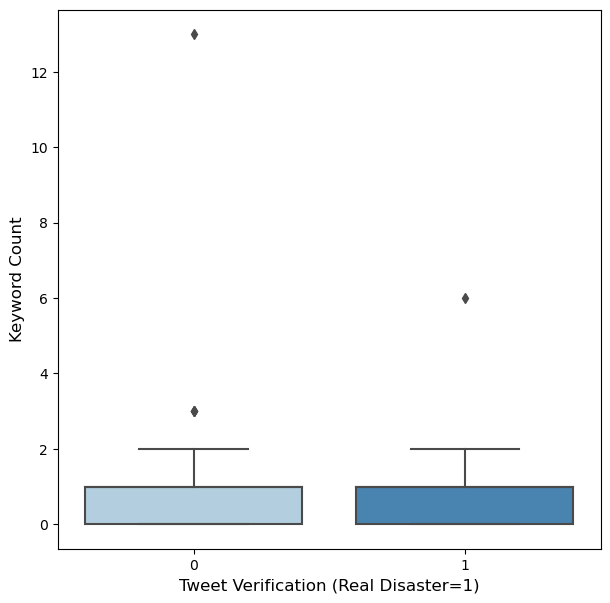

In [23]:
plt.figure(figsize=(7,7))
keyword_count = sns.boxplot(x='target', y='count_keyword', data=filtered_df_train, palette="Blues")
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Keyword Count', fontsize=12);

## Data Cleaning

#### Duplicates

While duplicates can signal that an organization explicitly needed to retween a particular tweet, we have duplicates in both real and not real tweets. 

In [24]:
duplicate_rows = df_train.duplicated(subset=['text'])

In [25]:
duplicate_rows.value_counts()

False    7503
True      110
dtype: int64

In [26]:
df_filtered = df_train[df_train.duplicated(subset=['text']) == True]

In [27]:
#df_test_filtered = df_test[df_test.duplicated(subset=['text']) == True]

In [28]:
pd.set_option('display.max_rows', None)

In [29]:
df_train[df_train.duplicated(subset=['text'], keep=False)].groupby("target").count()

,id,keyword,location,text,text_words,character_count
target,,,,,,
0,58,58,30,58,58,58
1,121,116,68,121,121,121


In [30]:
df_train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [31]:
target_1 = 121/3271
target_1

0.03699174564353409

In [32]:
target_0 = 58/4342
target_0

0.013357899585444496

In [33]:
df_filtered = df_train.drop_duplicates(subset=['text'])

New filtered dataset

In [34]:
df_filtered.shape

(7503, 7)

#### Cleaning Function

In [35]:
def tweet_cleaner(text):
    pattern = r'\b[a-zA-Z]+\b'
    pattern1 = " #abcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)

    # including new stopwords unique to tweets. and adding them to nltk
    stops = nltk.corpus.stopwords.words('english')
    new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "co", "amp", "url"]
    stops.extend(new_stop_words)
    
    text = ''.join(c for c in text if c in pattern1)
    text = re.sub(r'@\S+','',text) # removes usernames
    text = re.sub(r'http://\S+','',text) # removes urls
    text = re.sub(r'https://\S+','',text)
    text = re.sub(r'www.\S+','',text)
    text = emoji_pattern.sub(r'', text)
    
    
    words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1)]
    sentence = " ".join(words)
    
    return sentence

In [36]:
df_train_copy = df_filtered['text'].apply(lambda txt: tweet_cleaner(txt))

In [37]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return(" ".join(x))

df_train_copy_lemm = df_train_copy.apply(lemmatize_text)

In [38]:
df_filtered_df = pd.DataFrame(df_train_copy_lemm)

#### Data Overview

In [39]:
stops = nltk.corpus.stopwords.words('english')
new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "co", "amp", "url", "go", "get", "via","im", "dont","us"]
stops.extend(new_stop_words)

In [40]:
cvec_lemm = CountVectorizer(stop_words=stops)
cvec_lemm.fit(df_filtered_df["text"])
cvec_lemm_data = cvec_lemm.transform(df_filtered_df["text"])
df_lemm = pd.DataFrame(cvec_lemm_data.todense(), columns=cvec_lemm.get_feature_names_out())

In [41]:
df_lemm_ = pd.merge(df_lemm, df_filtered["target"], left_index=True, right_index=True)

In [42]:
df_1 = df_train[df_train["target"] == 1]
df_0 = df_train[df_train["target"] == 0]

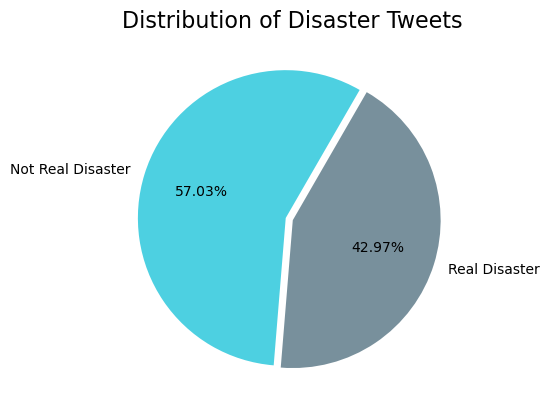

In [43]:
colors = ['#4dd0e1','#78909c']
plt.pie(df_train['target'].value_counts(),
            labels=['Not Real Disaster', 'Real Disaster'],
            autopct='%1.2f%%',
            shadow=False,
            explode=(0.05, 0),
            startangle=60,
            colors=colors);
plt.title(
    label="Distribution of Disaster Tweets", 
    fontdict={"fontsize":16},
);
plt.savefig('../images/tweet_distribution.png')

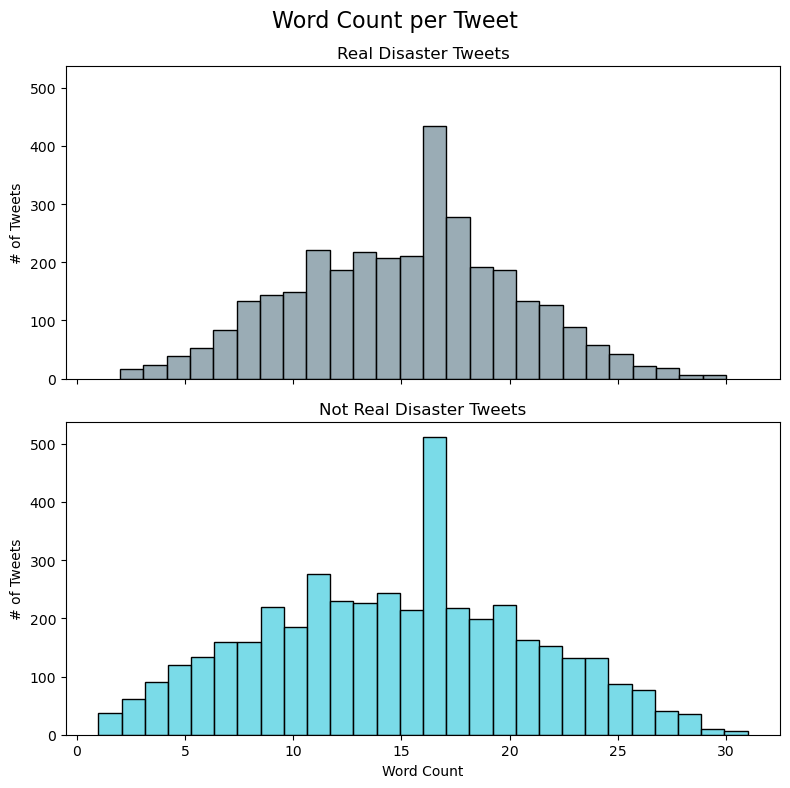

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_1, x=df_1['text_words'], color='#78909c', ax=axes[0]).set(title='Real Disaster Tweets')
sns.histplot(data=df_0, x=df_0["text_words"], color='#4dd0e1', ax=axes[1]).set(title='Not Real Disaster Tweets')
axes[0].set_xlabel('Word Count')
axes[1].set_xlabel('Word Count')
axes[0].set_ylabel('# of Tweets')
axes[1].set_ylabel('# of Tweets')
fig.suptitle('Word Count per Tweet', fontsize=16);
fig.savefig("../images/word_count.png") 
# Add a Super Title
#fig.suptitle('Distribution of Word Count by Dataset', ha='center')
#plt.savefig("Word_Count_data.png")

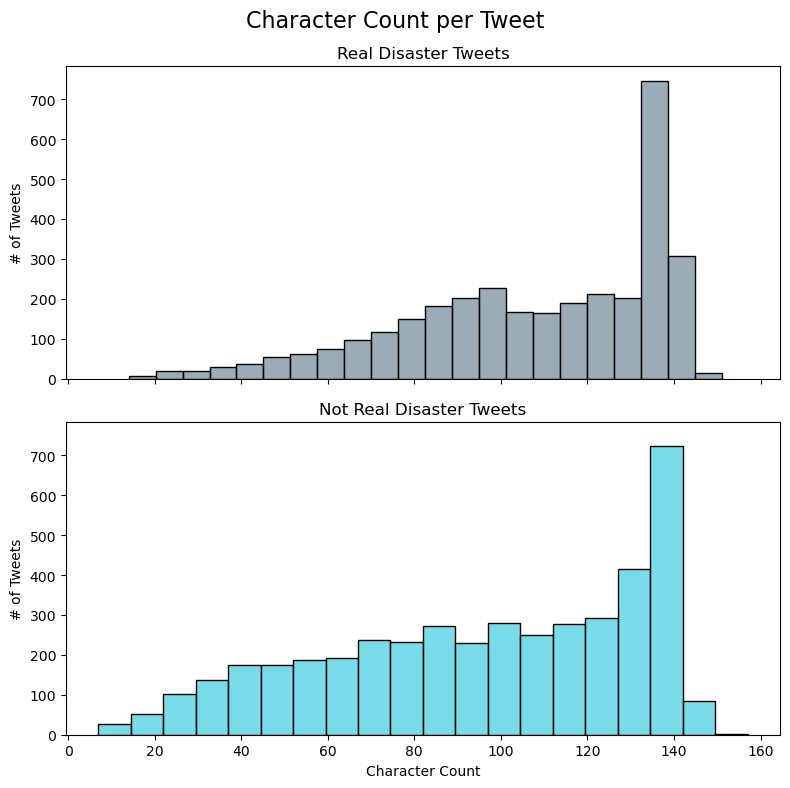

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_1, x=df_1['character_count'], color='#78909c', ax=axes[0]).set(title='Real Disaster Tweets')
sns.histplot(data=df_0, x=df_0["character_count"], color='#4dd0e1', ax=axes[1]).set(title='Not Real Disaster Tweets')
axes[0].set_xlabel('Character Count')
axes[1].set_xlabel('Character Count')
axes[0].set_ylabel('# of Tweets')
axes[1].set_ylabel('# of Tweets')
fig.suptitle('Character Count per Tweet', fontsize=16);
fig.savefig("../images/character_count.png") 
# Add a Super Title
#fig.suptitle('Distribution of Word Count by Dataset', ha='center')
#plt.savefig("Word_Count_data.png")

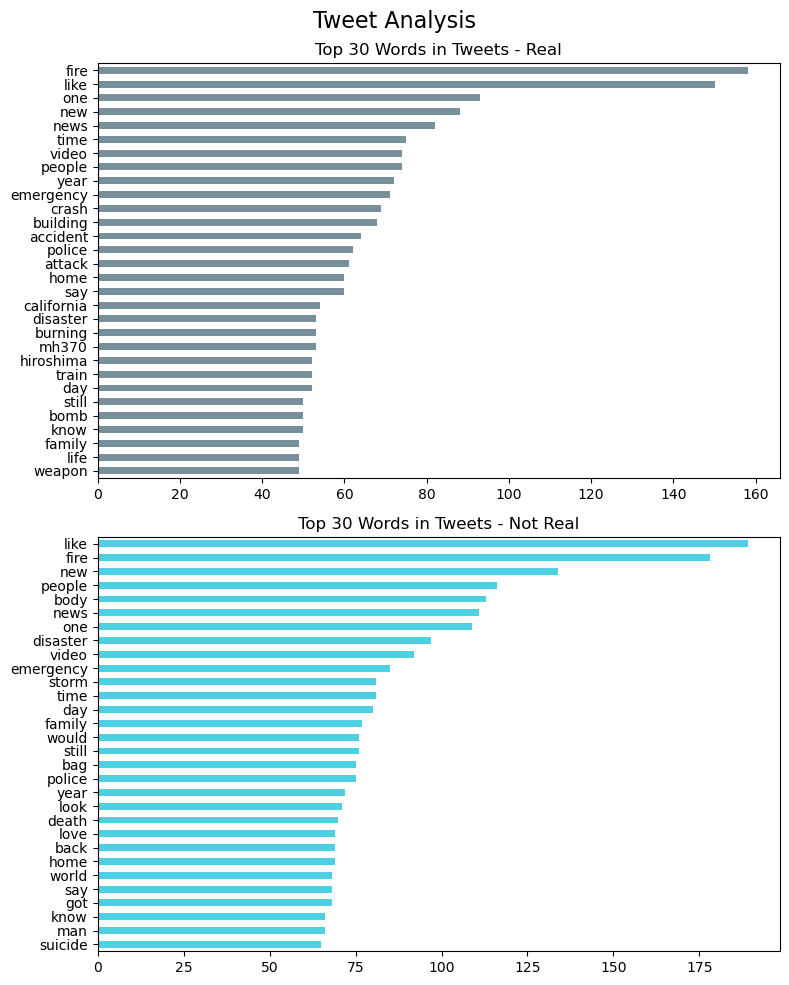

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_lemm_[df_lemm_['target_y'] == 1]
    .drop(columns=['target_y'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top 30 Words in Tweets - Real', color='#78909c', ax=axes[0])).invert_yaxis();

(df_lemm_[df_lemm_['target_y'] == 0]
    .drop(columns=['target_y'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top 30 Words in Tweets - Not Real', color='#4dd0e1', ax=axes[1])).invert_yaxis(); 

fig.suptitle('Tweet Analysis', fontsize=16);
plt.savefig('../images/Unigrams.png')

In [47]:
cvec_lemm_2 = CountVectorizer(ngram_range=(2, 2),stop_words=stops)
cvec_lemm_2.fit(df_filtered_df["text"])
cvec_lemm_data_2 = cvec_lemm_2.transform(df_filtered_df["text"])
df_lemm_2 = pd.DataFrame(cvec_lemm_data_2.todense(), columns=cvec_lemm_2.get_feature_names_out())

In [48]:
df_lemm_2_ = pd.merge(df_lemm_2, df_filtered["target"], left_index=True, right_index=True)

In [49]:
cvec_lemm_3 = CountVectorizer(ngram_range=(3, 3),stop_words=stops)
cvec_lemm_3.fit(df_filtered_df["text"])
cvec_lemm_data_3 = cvec_lemm_3.transform(df_filtered_df["text"])
df_lemm_3 = pd.DataFrame(cvec_lemm_data_3.todense(), columns=cvec_lemm_3.get_feature_names_out())

In [50]:
df_lemm_3_ = pd.merge(df_lemm_3, df_filtered["target"], left_index=True, right_index=True)

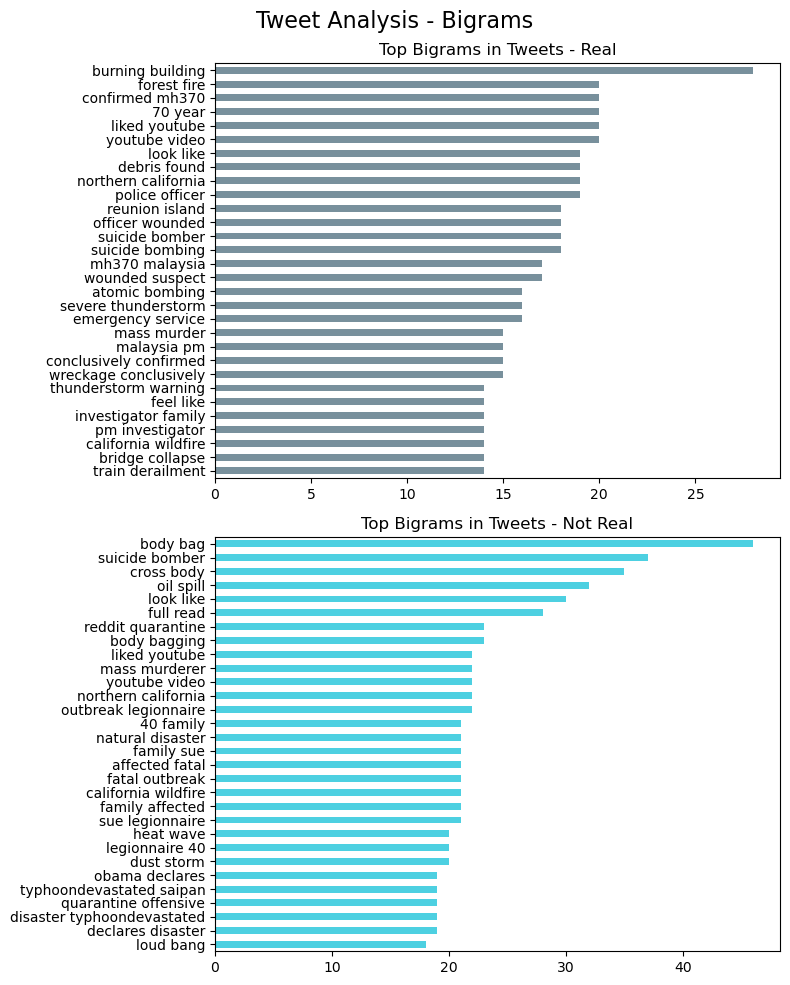

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_lemm_2_[df_lemm_2_['target'] == 1]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Bigrams in Tweets - Real', color='#78909c', ax=axes[0])).invert_yaxis();


(df_lemm_2_[df_lemm_2_['target'] == 0]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Bigrams in Tweets - Not Real', color='#4dd0e1', ax=axes[1])).invert_yaxis();

fig.suptitle('Tweet Analysis - Bigrams', fontsize=16);
plt.savefig('../images/Bigrams.png')

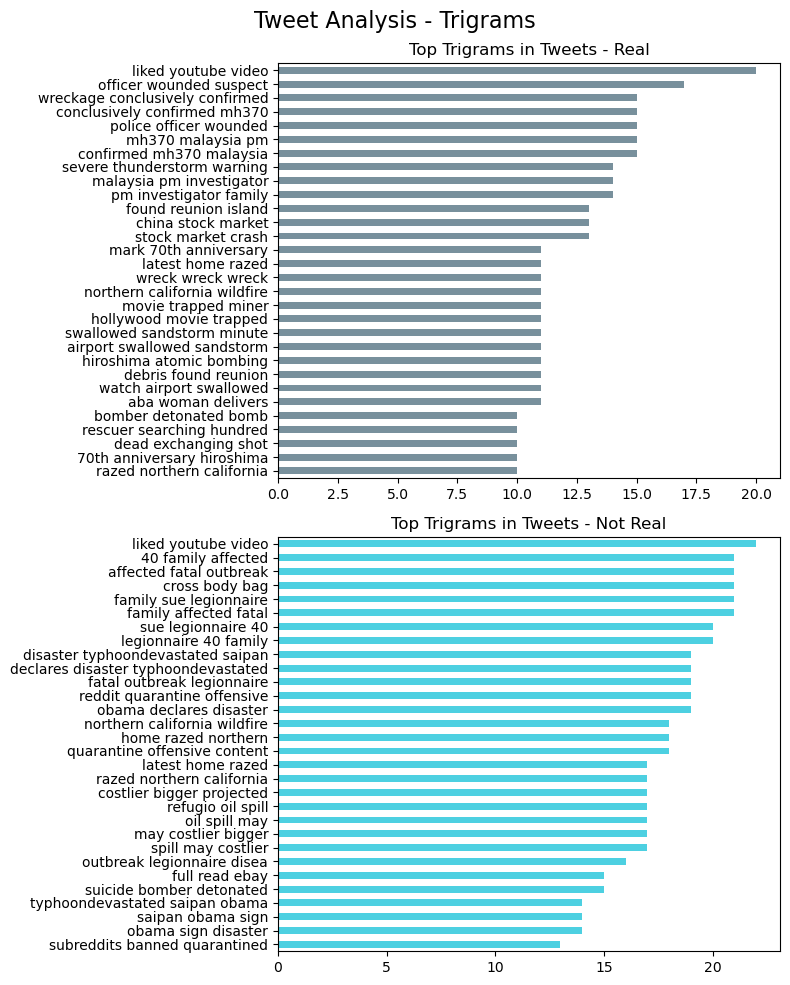

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_lemm_3_[df_lemm_3_['target'] == 1]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams in Tweets - Real', color='#78909c', ax=axes[0])).invert_yaxis();


(df_lemm_3_[df_lemm_3_['target'] == 0]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams in Tweets - Not Real', color='#4dd0e1', ax=axes[1])).invert_yaxis();

fig.suptitle('Tweet Analysis - Trigrams', fontsize=16);
plt.savefig('../images/Trigrams.png')

## Data Findings

In [53]:
# use of hashtags
df_train["hashtags"] = list(map(lambda x: x.count("#"), df_train['text']))

#### Number of Hashtags

In [54]:
symbol00 = df_train.groupby("target")["hashtags"].aggregate(["sum", "mean"]).reset_index()

In [55]:
symbol00

,target,sum,mean
0,0,1700,0.391525
1,1,1703,0.520636


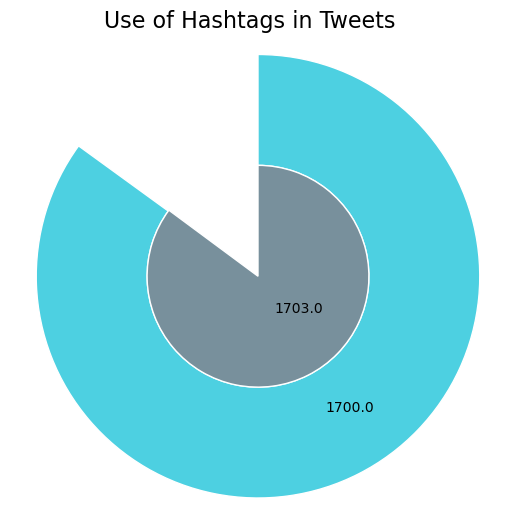

In [56]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol00["sum"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol00["sum"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Use of Hashtags in Tweets', fontsize=16, y=1.05)
plt.savefig('../images/Hashtags.jpg')
plt.show()


In [57]:
# nu. URLs
df_train["urls"] = list(sum(y.count(x) for x in ("www","http","https")) for y in df_train['text'])


#### Number of URLs

In [58]:
symbol0 = df_train.groupby("target")["urls"].aggregate(["sum", "mean"]).reset_index()
symbol0

,target,sum,mean
0,0,2486,0.572547
1,1,2658,0.812596


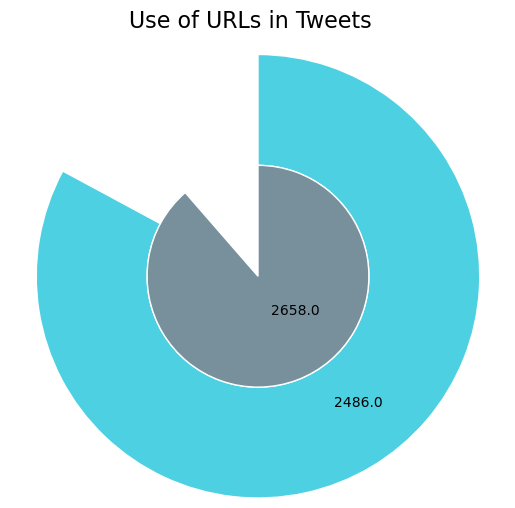

In [59]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol0["sum"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol0["sum"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Use of URLs in Tweets', fontsize=16, y=1.05)
plt.savefig('../images/URLs.png')
plt.show()


In [60]:
# use of @
df_train["@"] = list(map(lambda x: x.count("@"), df_train['text']))

#### Number of User References "@"

In [61]:
symbol1 = df_train.groupby("target")["@"].aggregate(["sum", "mean"]).reset_index()
symbol1

,target,sum,mean
0,0,1854,0.426992
1,1,905,0.276674


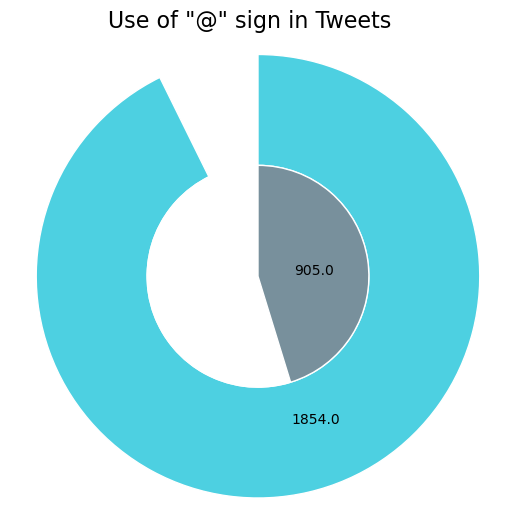

In [62]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol1["sum"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol1["sum"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Use of "@" sign in Tweets', fontsize=16, y=1.05)
plt.savefig('../images/Users.png')
plt.show()


#### Number of Duplicates

In [63]:
# duplicates
symbol2 = df_train[df_train.duplicated(subset=['text'], keep=False)].groupby("target").count().reset_index()

In [64]:
symbol2

,target,id,keyword,location,text,text_words,character_count,hashtags,urls,@
0,0,58,58,30,58,58,58,58,58,58
1,1,121,116,68,121,121,121,121,121,121


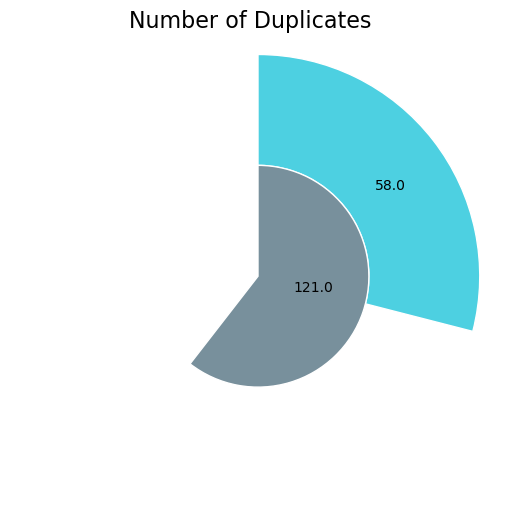

In [65]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol2["id"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol2["id"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Number of Duplicates', fontsize=16, y=1.05)
plt.savefig('../images/Duplicates.png')
plt.show()


In [66]:
symbol3 = df_filtered[df_filtered.duplicated(subset=['text'], keep=False)].groupby("target").count()
df_filtered[df_filtered.duplicated(subset=['text']) == True]

,id,keyword,location,text,target,text_words,character_count


## Modeling 

#### Bernoulli

**Count Vector**

In [67]:
X_lemm = df_filtered_df["text"]
y = df_filtered["target"]

In [68]:
df_test_copy = df_test['text'].apply(lambda txt: tweet_cleaner(txt))

In [69]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return(" ".join(x))

df_test_copy_lemm = df_test_copy.apply(lemmatize_text)

In [70]:
df_test_df = pd.DataFrame(df_test_copy_lemm)

In [71]:
X_lemm_test = df_test_df["text"]

In [72]:
X_lemm.to_csv('../data/misc data/X.csv')
y.to_csv('../data/misc data/y.csv')

In [73]:
Xn_train, Xn_traintest, y_train, y_traintest = train_test_split(X_lemm,
                                                    y,
                                                    random_state=42, stratify=y)

In [74]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [75]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [76]:
gs_n = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [77]:
gs_n.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [78]:
gs_n.best_score_

0.7924258140911783

In [79]:
print(gs_n.score(Xn_train,y_train))
print(gs_n.score(Xn_traintest,y_traintest))

0.838279722765239
0.8166311300639659


In [80]:
preds_gs_n = gs_n.predict(Xn_traintest)

In [81]:
#with help from Kalpa

def evaluation(name_of_the_model, y_test, preds, gs_model):
    ## find the confusion matrix
    cm = confusion_matrix(y_test, preds)
    tp = cm[1][1]; #True positives
    tn = cm[0][0]; #True negatives
    fp = cm[0][1]; #False positives
    fn = cm[1][0]; #False negatives

    #Calculate Sensitivity, Specificity, Precision, and F1_Score

    Sensitivity = round(tp/(tp + fn),3)
    Specificity = round(tn/(tn + fp),3)
    Precision = round(tp/(tp + fp),3)
    F1_Score = round(2 * (Precision * Sensitivity) / (Precision + Sensitivity),3)

    #Model scores for train and test

    train_score = round(gs_model.score(Xn_train, y_train),3)
    test_score = round(gs_model.score(Xn_traintest, y_traintest),3)

    #Create a dataframe to compare the results
    df = pd.DataFrame(
        {'Model' : name_of_the_model,
        'Score on train': train_score ,
        'Score on test': test_score,
         'Sensitivity': Sensitivity,
         'Specificity': Specificity,
         'Precision' : Precision,
         'F1 Score' : F1_Score
        },index=[0]
    )

    return df #Display the dataframe

In [82]:
bernoulli = evaluation("Bernoulli CVEC", y_traintest, preds_gs_n, gs_n)

In [83]:
from sklearn.metrics import classification_report

In [84]:
print(classification_report(y_train, gs_n.predict(Xn_train))) 

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      3229
           1       0.89      0.71      0.79      2398

    accuracy                           0.84      5627
   macro avg       0.85      0.82      0.83      5627
weighted avg       0.84      0.84      0.83      5627



In [85]:
print(classification_report(y_traintest, gs_n.predict(Xn_traintest))) 

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1076
           1       0.86      0.68      0.76       800

    accuracy                           0.82      1876
   macro avg       0.83      0.80      0.81      1876
weighted avg       0.82      0.82      0.81      1876



In [86]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [87]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(pipe, pipe_params, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(Xn_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(Xn_traintest)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_traintest, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [88]:
grid_search_gs_n = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (2, 2), 'cvec__stop_words': 'english'}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg      1061        15
pos       503       297


In [89]:
results = pd.DataFrame(grid_search_gs_n.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,params,...,split2_train_accuracy_score,split3_train_accuracy_score,split4_train_accuracy_score,split5_train_accuracy_score,split6_train_accuracy_score,split7_train_accuracy_score,split8_train_accuracy_score,split9_train_accuracy_score,mean_train_accuracy_score,std_train_accuracy_score
2,1.262872,0.082851,0.097723,0.056733,0.9,5000,2,"(2, 2)",english,"{'cvec__max_df': 0.9, 'cvec__max_features': 50...",...,0.744866,0.744076,0.743483,0.748025,0.748025,0.746496,0.745903,0.746101,0.745414,0.001680
8,0.875600,0.088749,0.060420,0.030185,0.95,5000,2,"(2, 2)",english,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",...,0.744866,0.744076,0.743483,0.748025,0.748025,0.746496,0.745903,0.746101,0.745414,0.001680
5,1.137255,0.103589,0.092705,0.065580,0.9,5000,5,"(2, 2)",english,"{'cvec__max_df': 0.9, 'cvec__max_features': 50...",...,0.688191,0.687006,0.688586,0.691746,0.692733,0.688450,0.687660,0.686871,0.688407,0.002215
11,0.474769,0.079343,0.042011,0.029080,0.95,5000,5,"(2, 2)",english,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",...,0.688191,0.687006,0.688586,0.691746,0.692733,0.688450,0.687660,0.686871,0.688407,0.002215
1,1.498863,0.449394,0.123289,0.058956,0.9,5000,2,"(1, 2)",english,"{'cvec__max_df': 0.9, 'cvec__max_features': 50...",...,0.839455,0.838665,0.834321,0.839850,0.838863,0.835341,0.838697,0.839684,0.837944,0.001781


**TFIDF**

In [90]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [91]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [92]:
gs_n_tvec = GridSearchCV(pipe_tvec, 
                  pipe_params_tvec, 
                  cv = 5)

In [93]:
gs_n_tvec.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [94]:
gs_n_tvec.best_score_

0.7924258140911783

In [95]:
print(gs_n_tvec.score(Xn_train,y_train))
print(gs_n_tvec.score(Xn_traintest,y_traintest))

0.838279722765239
0.8166311300639659


In [96]:
preds_gs_n_tvec = gs_n_tvec.predict(Xn_traintest)

In [97]:
bernoulli_tvec = evaluation("Bernoulli TFIDF", y_traintest, preds_gs_n_tvec, gs_n_tvec)

#### Logistic Regression

**Count Vector**

In [98]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [99]:
gs_n_logr = GridSearchCV(pipe_logr, 
                  pipe_params, 
                  cv = 5)

In [100]:
gs_n_logr.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [101]:
gs_n_logr.best_score_

0.7961591474245115

In [102]:
print(gs_n_logr.score(Xn_train,y_train))
print(gs_n_logr.score(Xn_traintest,y_traintest))

0.8937266749600142
0.8150319829424307


In [103]:
preds_gs_n_logr = gs_n_logr.predict(Xn_traintest)

In [104]:
logr_cvec = evaluation("Logistic Regression CVEC", y_traintest, preds_gs_n_logr, gs_n_logr)

**TFIDF**

In [105]:
pipe_tvec_logr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [106]:
gs_n_tvec_logr = GridSearchCV(pipe_tvec_logr, 
                pipe_params_tvec, 
                  cv = 5)

In [107]:
gs_n_tvec_logr.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [108]:
gs_n_tvec_logr.best_score_

0.7931388198144859

In [109]:
print(gs_n_tvec_logr.score(Xn_train,y_train))
print(gs_n_tvec_logr.score(Xn_traintest,y_traintest))

0.9114981339968011
0.8043710021321961


In [110]:
preds_gs_n_tvec_logr = gs_n_tvec_logr.predict(Xn_traintest)

In [111]:
logr_tvec = evaluation("Logistic Regression TFIDF", y_traintest, preds_gs_n_tvec_logr, gs_n_tvec_logr)

#### Random Forest

**Count Vector**

In [112]:
pipe_rf_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])


In [113]:
rf_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
    'rf__n_estimators' : [100, 150, 200],
    'rf__max_depth': [None, 3, 4, 5, 6, 7]
}

In [114]:
gs_dt_n = GridSearchCV(pipe_rf_cvec, rf_params, cv=5, n_jobs=-1)
gs_dt_n.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english'],
                         'rf__max_depth': [None, 3, 4, 5, 6, 7],
                         'rf__n_estimators': [100, 150, 200]})

In [115]:
print(gs_dt_n.score(Xn_train,y_train))
print(gs_dt_n.score(Xn_traintest,y_traintest))

0.9868491203127777
0.7782515991471215


In [116]:
preds_gs_dt_n = gs_dt_n.predict(Xn_traintest)

In [117]:
rf_cvec = evaluation("Random Forest CVEC", y_traintest, preds_gs_dt_n, gs_dt_n)

**TFIDF**

In [118]:
pipe_rf_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])


In [119]:
rf_params_tvec = {
   'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english'],
    'rf__n_estimators' : [100, 150, 200],
    'rf__max_depth': [None, 3, 4, 5, 6, 7]
}

In [120]:
gs_dt_n_tvec = GridSearchCV(pipe_rf_tvec, rf_params_tvec, cv=5, n_jobs=-1)
gs_dt_n_tvec.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 3, 4, 5, 6, 7],
                         'rf__n_estimators': [100, 150, 200],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [121]:
preds_gs_dt_tvec_n = gs_dt_n_tvec.predict(Xn_traintest)

In [122]:
rf_tvec = evaluation("Random Forest TFIDF", y_traintest, preds_gs_dt_tvec_n, gs_dt_n_tvec)

#### ADA Boost + Random Forest

**Count Vector**

In [123]:
pipe_abc = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(random_state = 42,estimator=RandomForestClassifier( )))
])

In [124]:
pipe_params_abc = {
    'ada__n_estimators': [5,10],
    'ada__algorithm' : ['SAMME.R'],
    'ada__learning_rate' :[0.0,0.1,1.0]
    
}

In [125]:
gs_cvec_abc = GridSearchCV(pipe_abc, 
                  pipe_params_abc, 
                  cv = 5)

In [126]:
dt_abc_n = gs_cvec_abc.fit(Xn_train, y_train)

/Users/polinaminkovski/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/polinaminkovski/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/polinaminkovski/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/polinaminkovski/anaconda3/lib/python3.11/site-p

In [127]:
print(dt_abc_n.score(Xn_train, y_train))
print(dt_abc_n.score(Xn_traintest, y_traintest))

0.9994668562288964
0.7995735607675906


In [128]:
preds_dt_abc_n = dt_abc_n.predict(Xn_traintest)

In [129]:
ada_cvec = evaluation("ADA Boost Random Forest CVEC", y_traintest, preds_dt_abc_n,dt_abc_n)

**TFIDF**

In [130]:
pipe_abc_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(random_state = 42,estimator=RandomForestClassifier( )))
])

In [131]:
pipe_params_abc_tvec = {
    'ada__n_estimators': [5,10],
    'ada__algorithm' : ['SAMME.R'],
    'ada__learning_rate' :[0.0,0.1,1.0]
    
}

In [132]:
gs_cvec_abc_tvec = GridSearchCV(pipe_abc_tvec, 
                  pipe_params_abc_tvec, 
                  cv = 5)

In [133]:
dt_abc_n_tvec = gs_cvec_abc_tvec.fit(Xn_train, y_train)

/Users/polinaminkovski/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/polinaminkovski/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/polinaminkovski/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/polinaminkovski/anaconda3/lib/python3.11/site-p

In [134]:
print(dt_abc_n_tvec.score(Xn_train, y_train))
print(dt_abc_n_tvec.score(Xn_traintest, y_traintest))

0.9994668562288964
0.7953091684434968


In [135]:
preds_dt_abc_n_tvec = dt_abc_n_tvec.predict(Xn_traintest)

In [136]:
ada_tvec = evaluation("ADA Boost Random Forest TFIDF", y_traintest, preds_dt_abc_n_tvec, dt_abc_n_tvec)

#### Decision Tree

**Count Vector**

In [137]:
pipe_dtc = Pipeline([
    ('cvec', CountVectorizer()),
    ('dtc', DecisionTreeClassifier())
])

In [138]:
pipe_params_dtc = {
    'cvec__max_features' : [500],
    'cvec__min_df' : [10],
    'cvec__max_df' : [0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
    'dtc__max_depth': [None],      
    'dtc__min_samples_split': [10],        
    'dtc__min_samples_leaf': [1],      
    'dtc__max_features': ['log2'],
    'dtc__ccp_alpha' : [0.0],
    'dtc__min_impurity_decrease' : [0],
    
}
#Some assist from Kalpa on building the params here

In [139]:
gs_cvec_dtc = GridSearchCV(pipe_dtc, 
                  pipe_params_dtc, 
                  cv = 5, error_score='raise')

In [140]:
dt_n = gs_cvec_dtc.fit(Xn_train, y_train)

In [141]:
print(dt_n.score(Xn_train, y_train))
print(dt_n.score(Xn_traintest, y_traintest))

0.8761329305135952
0.7494669509594882


In [142]:
preds_dtc_n = dt_n.predict(Xn_traintest)

In [143]:
dtc_cvec = evaluation("Decision Tree CVEC", y_traintest, preds_dtc_n,dt_n)

**TFIDF**

In [144]:
pipe_dtc_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('dtc', DecisionTreeClassifier())
])

In [145]:
pipe_params_dtc_tvec = { 
    'tvec__max_features' : [500],
    'tvec__min_df' : [10],
    'tvec__max_df' : [0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english'],
    'dtc__max_depth': [None],      
    'dtc__min_samples_split': [10],        
    'dtc__min_samples_leaf': [1],      
    'dtc__max_features': ['log2'],
    'dtc__ccp_alpha' : [0.0],
    'dtc__min_impurity_decrease' : [0],
    
}

In [146]:
gs_tvec_dtc = GridSearchCV(pipe_dtc_tvec, 
                  pipe_params_dtc_tvec, 
                  cv = 5)

In [147]:
dt_n_tvec = gs_tvec_dtc.fit(Xn_train, y_train)

In [148]:
print(gs_tvec_dtc.score(Xn_train, y_train))
print(gs_tvec_dtc.score(Xn_traintest, y_traintest))

0.8912386706948641
0.7281449893390192


In [149]:
preds_dtc_n_tvec = dt_n_tvec.predict(Xn_traintest)

In [150]:
dtc_tvec = evaluation("Decision Tree TFIDF", y_traintest, preds_dtc_n_tvec, dt_n_tvec)

## Final evaluation

In [151]:
Comparison = pd.concat([bernoulli,bernoulli_tvec, 
                        logr_cvec,logr_tvec,
                        rf_cvec,rf_tvec,
                        #ada_cvec,ada_tvec, 
                        dtc_cvec, dtc_tvec],ignore_index=True)

In [152]:
Comparison

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Bernoulli CVEC,0.838,0.817,0.680,0.918,0.861,0.760
1,Bernoulli TFIDF,0.838,0.817,0.680,0.918,0.861,0.760
2,Logistic Regression CVEC,0.894,0.815,0.691,0.907,0.847,0.761
3,Logistic Regression TFIDF,0.911,0.804,0.708,0.876,0.810,0.756
4,Random Forest CVEC,0.987,0.778,0.686,0.847,0.769,0.725
5,Random Forest TFIDF,0.987,0.786,0.670,0.872,0.795,0.727
6,Decision Tree CVEC,0.876,0.749,0.649,0.824,0.733,0.688
7,Decision Tree TFIDF,0.891,0.728,0.621,0.808,0.706,0.661


The model that achieved the best results (highest score on test data) while having the lowest overfitting was the Bernoulli (CVEC or TVEC). This will be the model we use for our submission, evaluation, and streamlit app.

TN: 840
FP: 236
FN: 161
TP: 639
Sensitivity: 0.79875
Specificity: 0.7806691449814126
Validation Accuracy: 0.7883795309168443


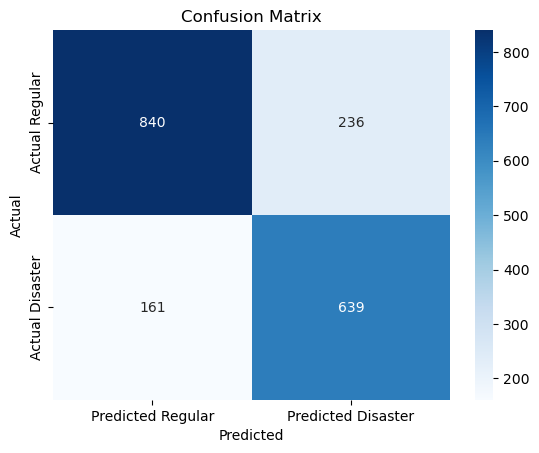

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_80796/2872825482.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


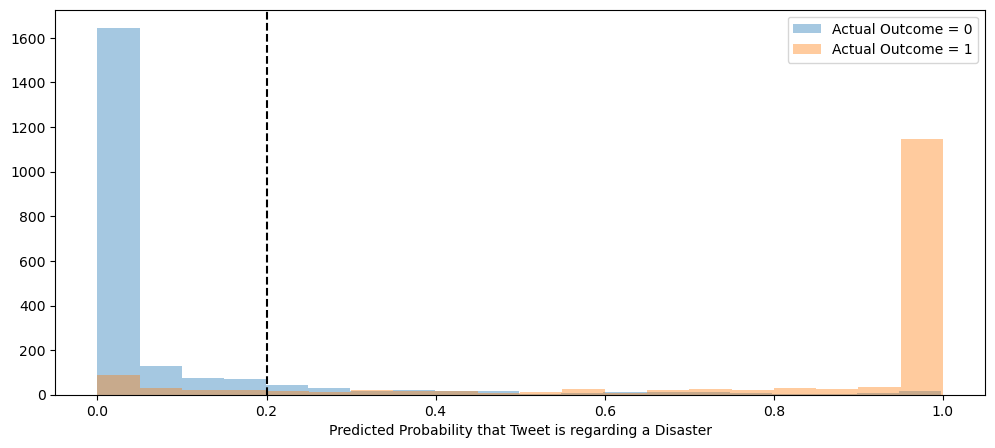

In [153]:
def sklearn_evaluation(model, X_test_in_model, y_test_truth, decision_boundary=0.2):

    predict_probs = model.predict_proba(X_test_in_model)[:,1]

    preds = (predict_probs > decision_boundary).astype(int)

    conf_matrix = confusion_matrix(y_test_truth, preds)

    tn, fp, fn, tp = conf_matrix.ravel()

    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('../images/Polina_Confusion.png')
    plt.show();

    reshaped_probs=predict_probs.tolist()
    
    pred_df = pd.DataFrame({'true_values': y_test_truth, 'pred_probs': predict_probs})

    plt.figure(figsize = (12, 5))
    # plot distributions of predicted probabilities by actual values
    for group in pred_df.groupby('true_values'):
        sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
    
    # Add cutoff line
    plt.axvline(decision_boundary, color = 'black', linestyle = '--')

    plt.xlabel('Predicted Probability that Tweet is regarding a Disaster')
    plt.legend();
    plt.savefig('../images/Polina_Prob_Graph.png')

sklearn_evaluation(gs_n, Xn_traintest, y_traintest)

## Submission

In [154]:
predictions = gs_n.predict(X_lemm_test)

In [155]:
import pickle

In [156]:
with open('../pickles/trial and error/X_test.pkl', 'wb') as f:
    pickle.dump(X_lemm_test, f)

In [ ]:
submission = pd.DataFrame({'id':df_test.id, 'target':predictions})

In [ ]:
submission["target"].value_counts()

In [ ]:
submission__ = submission.to_csv('../submissions/submission_cleaned.csv', index=False)

## Pickle model

In [ ]:
with open('../pickles/Bernoulli_Model.pkl', 'wb') as f:
    pickle.dump(gs_n, f)

In [ ]:
with open('../streamlit/Bernoulli_Model.pkl', 'wb') as f:
    pickle.dump(gs_n, f)

In [ ]:
with open('../pickles/Bernoulli_Model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
from nltk.stem import PorterStemmer

In [ ]:
def tweet_cleaner(text, stemmer = PorterStemmer()):
    pattern = r'\b[a-zA-Z]+\b'
    pattern1 = " #abcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)

    # including new stopwords unique to tweets. and adding them to nltk
    stops = nltk.corpus.stopwords.words('english')
    new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "co", "amp", "url"]
    stops.extend(new_stop_words)
    
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = WordNetLemmatizer()
    
    text = ''.join(c for c in text if c in pattern1)
    text = re.sub(r'@\S+','',text) # removes usernames
    text = re.sub(r'http://\S+','',text) # removes urls
    text = re.sub(r'https://\S+','',text)
    text = re.sub(r'www.\S+','',text)
    text = emoji_pattern.sub(r'', text)
    
    
    words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1)]
    sentence = " ".join(words)
    splits = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(sentence)]
    list_of_sentences = " ".join(splits)
    
    return list_of_sentences #list_of_words, list_of_stems, list_of_sentences, labels


In [ ]:
text = "ðŸ™ðŸ»ðŸŒˆðŸ™ðŸ How the West was burned: Thousands of wildfires ablaze in #California alone \\n http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0B"

In [ ]:
tweet_cleaner(text)

In [ ]:
text_c = input('Enter a disaster tweet here to check whether it\'s real or not: ')

text = tweet_cleaner(text_c)


prediction = model.predict([text])[0]


if prediction > 0.8:
  print(f"This disaster notification is: REAL.{prediction} Please stay safe!")
elif prediction > 0.5:
  print(f"This disaster notification might be: REAL.{prediction} Please work with your local news channel to learn more.")
else:
  print(f"This tweet is: NOT REAL.{prediction} Please enjoy your day!")

In [ ]:
p = model.predict_proba([text])
p